# Train CCtRNN Model on Multiple Tasks


In [27]:
# === SYSTEM PATH SETUP ===
import sys
from pathlib import Path
import copy

# Set the project root (the directory containing 'src/')
project_root = Path("/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus")
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# === STANDARD SCIENTIFIC LIBRARIES ===
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# === CUSTOM LIBRARIES ===
from src.utils.config_handling import create_experiment_config
from src.models.experiment_network import ExperimentNetwork
from src.data.data_generation import DataGenerator
from src.training.trainers.StandardTrainer import StandardTrainer
from src.analysis.visualisation import plot_training_analysis, plot_trial_type_comparison, plot_decoding_time, plot_decoding_learning, plot_task_accuracies
from src.models.model_factory import load_checkpoint_models, create_model_from_config
from src.analysis.utils import get_models_activations, identify_trial_types, get_percentile_indices, combine_phase_results, concatenate_training_results
from src.analysis.representations import decode_across_epochs_and_time
from src.experimenting.experiment_running import Experiment, ExperimentRunner




# === PLOTTING SETUP ===
sns.set_theme(context='notebook')
%config InlineBackend.figure_format = 'retina'  # 'svg' also works

## Step 1: Create Experiment Configuration

In [28]:
# -------------------------------------------------------------------------
# Step 1: Define and save the experiment configuration dictionary
# -------------------------------------------------------------------------
# We use the `create_experiment_config` utility to generate a hierarchical
# config object that specifies all key parameters for:
# - the temporal structure of each trial,
# - the dataset/task setup,
# - the model architecture (including controller),
# - training hyperparameters,
# - and hardware + reproducibility options.
#
# This config is automatically saved to disk as a YAML file, and can be 
# loaded later to reproduce the same experiment.

# Path to save the generated config file
save_path = Path("/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/configs")
config_fname = 'demo_multitask.yml'
config_path = save_path / config_fname

# Create the config dictionary and save it to disk
config = create_experiment_config(
    experiment_name="demo_multitask",  # Used to tag results and logs
    save_path=save_path,
    config_fname=config_fname,
    overwrite=True,  # Overwrite any existing config with same name

    # ---- Temporal structure of trials (ms) ----
    temporal={
        't_min': -500,            # Start time of trial
        't_max': 1500,            # End time of trial
        'dt': 20,                 # Time resolution (ms per step)
        'colour_onset': 0.0,      # When color cue starts
        'colour_offset': 1000.0,  # When color cue ends
        'shape_onset': 500.0,     # When shape cue starts
        'shape_offset': 1000.0,   # When shape cue ends
        'reward_onset': 1000.0,   # Reward cue starts
        'reward_offset': 1200.0   # Reward cue ends
    },

    # ---- Task and dataset configuration ----
    data={
        'n_trials': 1024,               # Total number of trials
        'input_noise_std': 0.15,        # Gaussian noise added to inputs
        'batch_size': 32,               # Training batch size
        'num_workers': 0,               # DataLoader worker threads
        'encoding_mode': 'orthogonal',  # How task features are encoded
        'experiment_type': 'abstract_binary_multitask',  # Task family (e.g. XOR, AND)
        'task_indices': [14, 7]            # Which abstract task(s) to use
    },

    # ---- Hardware / precision / reproducibility ----
    hardware={
        'device': 'cpu',           # Options: 'cpu', 'cuda', 'mps'
        'precision': 'float32',    # Tensor precision
        'deterministic': True      # Force deterministic ops for reproducibility
    },

    # ---- Model architecture and controller settings ----
    model={
        'type': 'ExperimentNetwork',     # Dispatches to CCtRNN + controller

        # Learning rule configuration
        'learning_rule': 'default',      # Can be 'hebb', 'maml', etc.
        'learning_rule_params': {},      # Optional args to pass to rule

        # Core RNN parameters (cortical dynamics)
        'network': {
            'input_size': 5,             # 3 input channels (task + features)
            'hidden_size': 40,           # Size of cortical recurrent population
            'output_size': 2,            # Binary output (reward / no reward)
            'tau': 50.0,                 # Membrane time constant (ms)
            'dt': 20.0,                  # Integration step (ms)
            'noise_std': 0.35,           # RNN Gaussian noise
            'nonlinearity': 'relu',      # Activation function
            'init_method': 'normal',     # Weight init scheme
            'init_g': 0.7                # Scaling of initial weights
        },

        # Optional random input layer
        'random_input': {
            'enabled': False,  # Whether to use random input expansion layer module
            'size': 30         # Size of random input layer
        },

        # Cerebellar controller configuration
        'controller': {
            'enabled': True,               # Whether to use controller module
            'type': 'simple',              # Controller class (e.g. simple, bioplausible - in future)
            'controller_hidden_size': 20,  # Hidden layer width (these args assume simple FF controller for now)
            'controller_hidden_n': 1,      # Number of controller hidden layers
            'controller_init_method': 'normal',
            'controller_init_g': 1,
            'nonlinearity': 'relu',
            'output_activation': 'relu',   # Output activation (post controller)
            'output_size': 2               # Size of controller input to RNN hidden layer
        },
    },

    # ---- Plasticity / trainable pathways ----
    plasticity={
        'input_plastic': True,             # Train input → hidden?
        'hidden_plastic': True,            # Train recurrent weights?
        'output_plastic': True,             # Train hidden → output?
        'h2controller_plastic': True,       # Train hidden → controller?
        'controller2h_plastic': True,       # Train controller → hidden?
        'controller_hidden_plastic': True   # Train controller internal weights?
    },

    # ---- Training hyperparameters ----
    training={
        'optimizer': 'Adam',
        'n_epochs': 50,
        'lr_rnn': 0.00033,                    # Learning rate for RNN weights
        'lr_controller': 0.001,             # Learning rate for controller weights
        'loss_type': 'crossentropy',
        'activations_l2': 0.0025,              # L2 penalty on hidden activations
        'weight_decay': 0.002,                # L2 penalty on weights
        'checkpoint_overwrite': True,       # Overwrite previous model?
        'checkpoint_path': "/Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/results/multitask_training/model_callbacks/testmodel1.pt",
        'checkpoint_frequency': 1           # Save every N epochs
    },

    # ---- Reproducibility ----
    reproducibility={
        'run_multiple': False,  # Run multiple seeds
        'seed': 42,             # Base random seed
        'n_seeds': 2,           # Number of distinct seeds (if run_multiple)
        'seed_increment': 13    # Increment between seeds
    }
)

Overwriting configuration file at /Users/marcus/Desktop/Oxford/NEUROSCIENCE/Projects/Cortico-Cerabellar/Code/Marcus/configs/demo_multitask.yml


## Step 2: Initialise the Data Generator


Analyzing abstract_binary_multitask – None

Design Matrix:


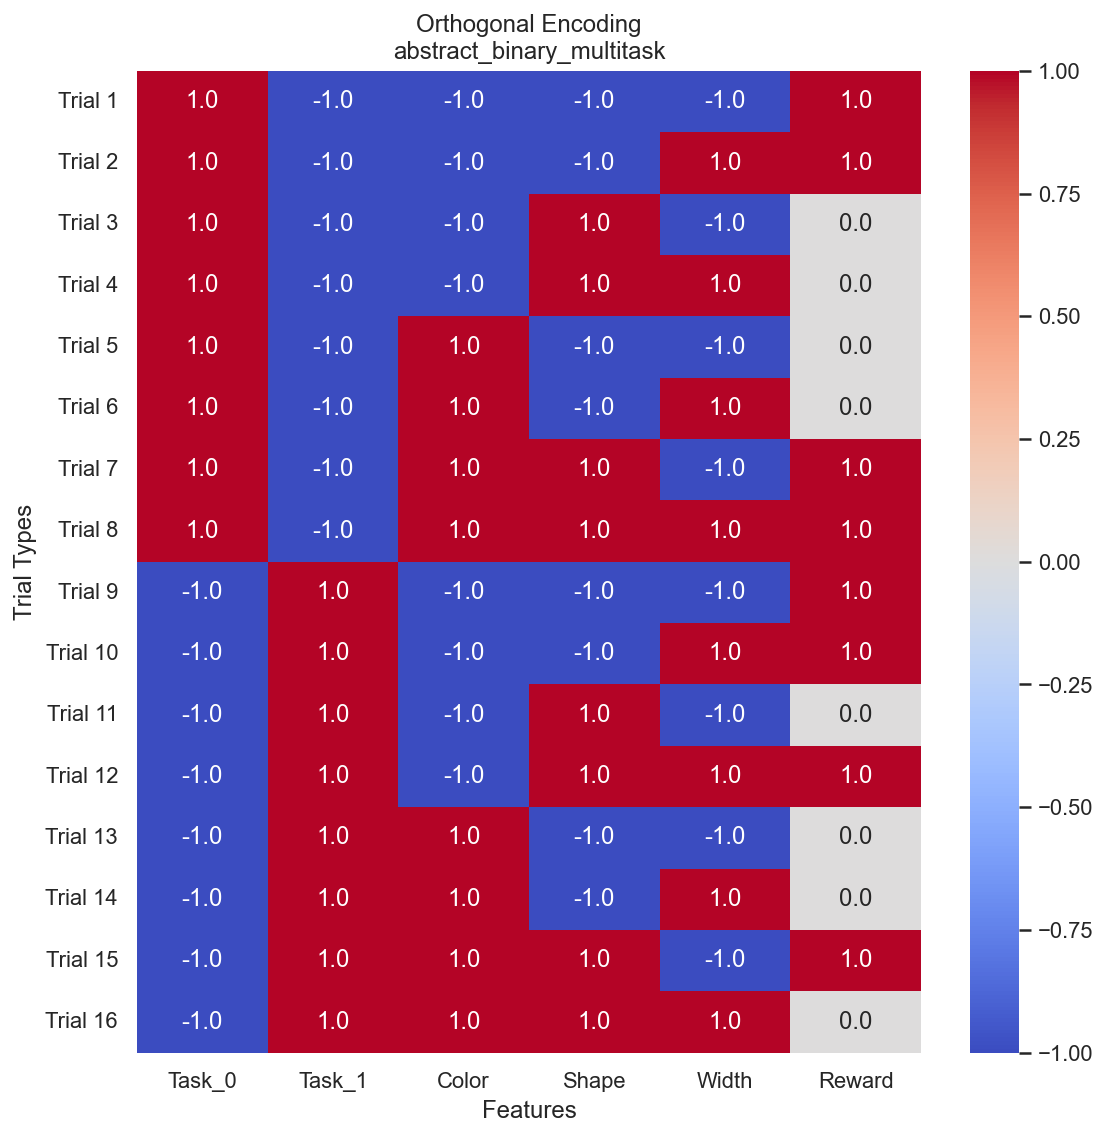


Event Sequence:


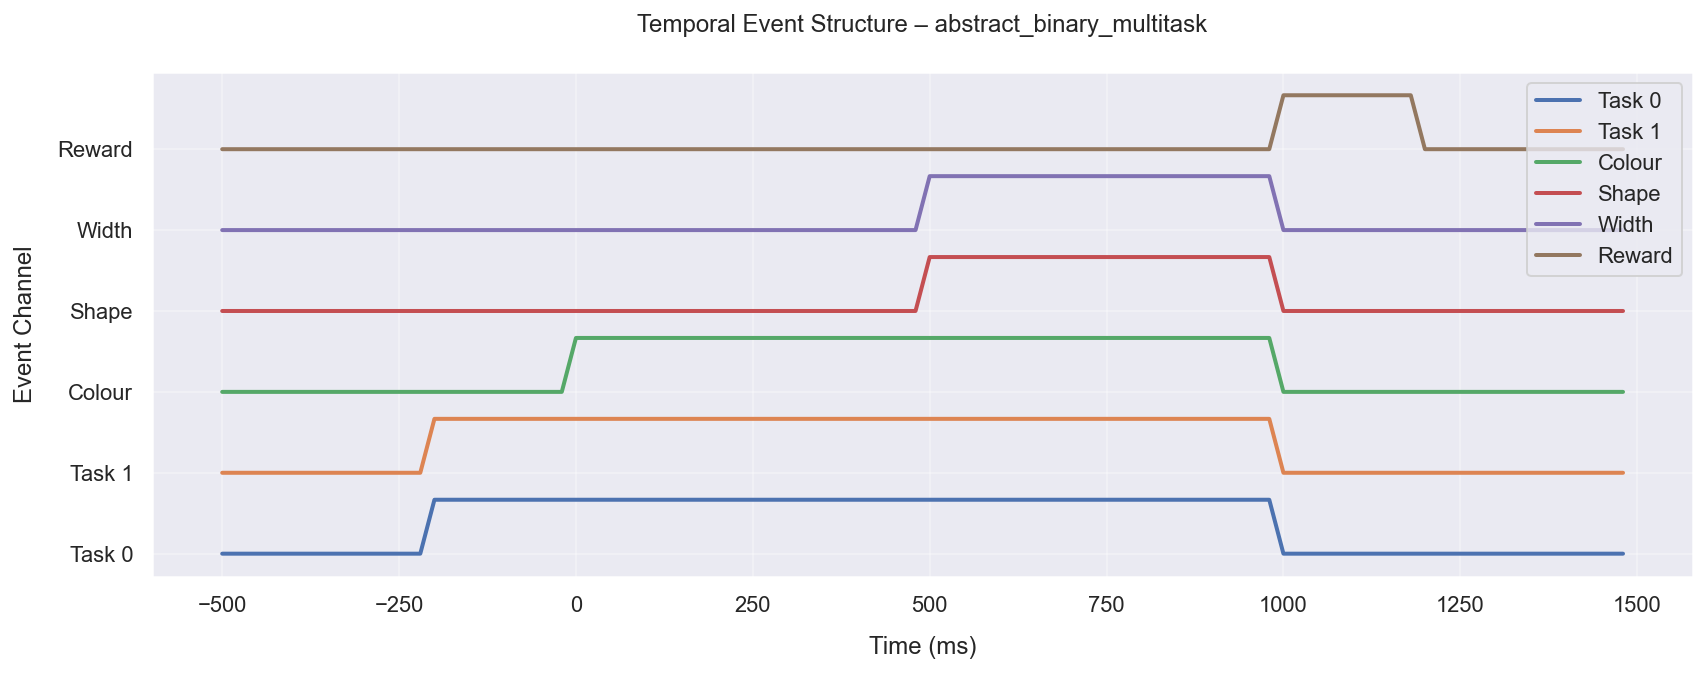


Trial Types:



abstract_binary_multitask Data Summary
Input shape: torch.Size([160, 100, 5])
Output shape: torch.Size([160, 100, 2])
Number of unique trial types: 16

Trial Type 0:
  Active Inputs: Color, Shape, Width
  Reward Present: Yes

Trial Type 1:
  Active Inputs: Color, Shape, Width
  Reward Present: Yes

Trial Type 2:
  Active Inputs: Color, Shape, Width
  Reward Present: No

Trial Type 3:
  Active Inputs: Color, Shape, Width
  Reward Present: No

Trial Type 4:
  Active Inputs: Color, Shape, Width
  Reward Present: No

Trial Type 5:
  Active Inputs: Color, Shape, Width
  Reward Present: No

Trial Type 6:
  Active Inputs: Color, Shape, Width
  Reward Present: Yes

Trial Type 7:
  Active Inputs: Color, Shape, Width
  Reward Present: Yes

Trial Type 8:
  Active Inputs: Color, Shape, Width
  Reward Present: Yes

Trial Type 9:
  Active Inputs: Color, Shape, Width
  Reward Present: Yes

Trial Type 10:
  Active Inputs: Color, Shape, Width
  Reward Present: No

Trial Type 11:
  Active Inputs: Color

In [29]:
# -------------------------------------------------------------------------
# Step 2: Initialise the Data Generator
# -------------------------------------------------------------------------
# This component produces structured input-output pairs for training.
# It uses the config to determine:
# - the timing of stimulus cues (color, shape, reward windows)
# - how inputs are encoded (e.g., orthogonal, one-hot)
# - which abstract task(s) to generate
# - number of trials and batch size

# Provide only the config path — everything else is parsed automatically
data_generator = DataGenerator(config_path=config_path)

# Plot to verify setup
data_generator.plot_experiment_summary()

## Step 3: Create the Model

In [30]:
ExperimentNetwork.set_seed(config['reproducibility']['seed'])
model = create_model_from_config(config)
model.to(device=config['hardware']['device'])

ExperimentNetwork(
  (model): CCtRNN(
    (activation): ReLU()
    (nonlinearity): ReLU()
    (controller): SimpleController(
      (nonlinearity): ReLU()
      (output_activation_function): ReLU()
      (input_layer): Linear(in_features=40, out_features=20, bias=True)
      (hidden_layers): ModuleList()
      (output_layer): Linear(in_features=20, out_features=2, bias=True)
      (main): Sequential(
        (0): Linear(in_features=40, out_features=20, bias=True)
        (1): ReLU()
        (2): Linear(in_features=20, out_features=2, bias=True)
      )
    )
    (controller2h): Linear(in_features=2, out_features=40, bias=True)
    (input2h): Linear(in_features=5, out_features=40, bias=True)
    (h2h): Linear(in_features=40, out_features=40, bias=True)
    (output_layer): Linear(in_features=40, out_features=2, bias=True)
  )
)

## Step 4: Train Model

Train model on 3-day curriculum with different tasks on each day?

In [36]:
task_list = [[17, 14],[34, 14],[7, 14]]

results =[]
for i_day in range(3):
    print('Training model on day ', str(i_day+1), ' tasks...')
    data_day = DataGenerator(config_path=config_path, task_indices=task_list[i_day])
    trainer_day = StandardTrainer(model, config, data_day)
    trainer_day.checkpoint.filepath = Path(config['training']['checkpoint_path'] + '_' + str(str(i_day+1)) + 'day.pt')
    results.append(trainer_day.train())

combined_results = concatenate_training_results(results, task_list)
plot_training_analysis([combined_results])
plot_trial_type_comparison(data_generator, model, config['hardware']['device'])

Training model on day  1  tasks...


Training: 100%|██████████| 50/50 [01:37<00:00,  1.95s/it, loss=0.1171, accuracy=0.9989]


Training model on day  2  tasks...


Training: 100%|██████████| 50/50 [01:37<00:00,  1.94s/it, loss=0.1157, accuracy=0.9998]


Training model on day  3  tasks...


Training: 100%|██████████| 50/50 [01:37<00:00,  1.95s/it, loss=0.1121, accuracy=1.0000]


Debugging each result before concatenation:

Result 1:

===== DEBUG TASK ACCURACIES =====
Format: LIST with 2 tasks
Task 0: 0 values
  EMPTY ARRAY - NO DATA
Task 1: 0 values
  EMPTY ARRAY - NO DATA


Result 2:

===== DEBUG TASK ACCURACIES =====
Format: LIST with 2 tasks
Task 0: 0 values
  EMPTY ARRAY - NO DATA
Task 1: 0 values
  EMPTY ARRAY - NO DATA


Result 3:

===== DEBUG TASK ACCURACIES =====
Format: LIST with 2 tasks
Task 0: 0 values
  EMPTY ARRAY - NO DATA
Task 1: 0 values
  EMPTY ARRAY - NO DATA

All unique tasks: {17, 34, 14, 7}
Epochs per day: 50, Total epochs: 150

Processing day 1 with tasks [17, 14]
  - Processing task 17 (idx 0)
    Found task data in list format, 0 values
    No data for task 17, leaving as zeros
  - Processing task 14 (idx 1)
    Found task data in list format, 0 values
    No data for task 14, leaving as zeros

Processing day 2 with tasks [34, 14]
  - Processing task 34 (idx 0)
    Found task data in list format, 0 values
    No data for task 34, leavin


Weight Norm Summary (Mean ± SEM across models):

input2h:
Initial Norm: 2.2764 ± 0.0000
Final Norm: 2.2142 ± 0.0000
Norm Change: -0.0622 ± 0.0000
Relative Change: -2.73% ± 0.00%

h2h:
Initial Norm: 2.3353 ± 0.0000
Final Norm: 2.1683 ± 0.0000
Norm Change: -0.1669 ± 0.0000
Relative Change: -7.15% ± 0.00%

output:
Initial Norm: 5.0519 ± 0.0000
Final Norm: 5.0267 ± 0.0000
Norm Change: -0.0252 ± 0.0000
Relative Change: -0.50% ± 0.00%

h2controller:
Initial Norm: 1.7793 ± 0.0000
Final Norm: 1.8762 ± 0.0000
Norm Change: 0.0969 ± 0.0000
Relative Change: 5.44% ± 0.00%

controller2h:
Initial Norm: 0.9974 ± 0.0000
Final Norm: 0.9814 ± 0.0000
Norm Change: -0.0160 ± 0.0000
Relative Change: -1.60% ± 0.00%

controller_hidden_0:
Initial Norm: 1.8284 ± 0.0000
Final Norm: 1.9378 ± 0.0000
Norm Change: 0.1094 ± 0.0000
Relative Change: 5.98% ± 0.00%

Firing Rate Summary (Mean ± SEM across models):
Initial Mean Rate: 0.0278 ± 0.0000
Final Mean Rate: 0.0328 ± 0.0000
Mean Rate Change: 0.0050 ± 0.0000
Rate Ra

In [26]:
task_descriptions = {
    14: "XOR",
    27: "day 1 task",
    34: "day 2 task",
    7:  "day 3 task"
}
plot_trial_type_comparison(data_generator, model, config['hardware']['device'])


Model Output Analysis:

Task 14:
Task type: Color XOR Shape

  Trial 0:
  True label: Reward
  Predicted: Reward
  Confidence: 4.707
  Correct: Yes

  Trial 1:
  True label: Reward
  Predicted: Reward
  Confidence: 2.683
  Correct: Yes

  Trial 2:
  True label: No Reward
  Predicted: No Reward
  Confidence: 3.864
  Correct: Yes

  Trial 3:
  True label: No Reward
  Predicted: Reward
  Confidence: 5.321
  Correct: No

  Trial 4:
  True label: No Reward
  Predicted: No Reward
  Confidence: 4.525
  Correct: Yes

  Trial 5:
  True label: No Reward
  Predicted: No Reward
  Confidence: 4.283
  Correct: Yes

  Trial 6:
  True label: Reward
  Predicted: Reward
  Confidence: 5.914
  Correct: Yes

  Trial 7:
  True label: Reward
  Predicted: No Reward
  Confidence: 6.629
  Correct: No

  Task Accuracy: 75.0%

Task 0:
Task type: Color

  Trial 0:
  True label: Reward
  Predicted: Reward
  Confidence: 6.545
  Correct: Yes

  Trial 1:
  True label: Reward
  Predicted: Reward
  Confidence: 4.448
  